In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': '90%',
        'height': '90%',
        'scroll': True,
})

{'width': '90%', 'height': '90%', 'scroll': True}

# Leveraging ML Advances

Modern machine learning and "AI" are built around stochastic gradient descent, which is in turn powered by reverse-mode automatic differentiation. In this notebook, we will see how these systems can be leveraged to help solve economic models.  

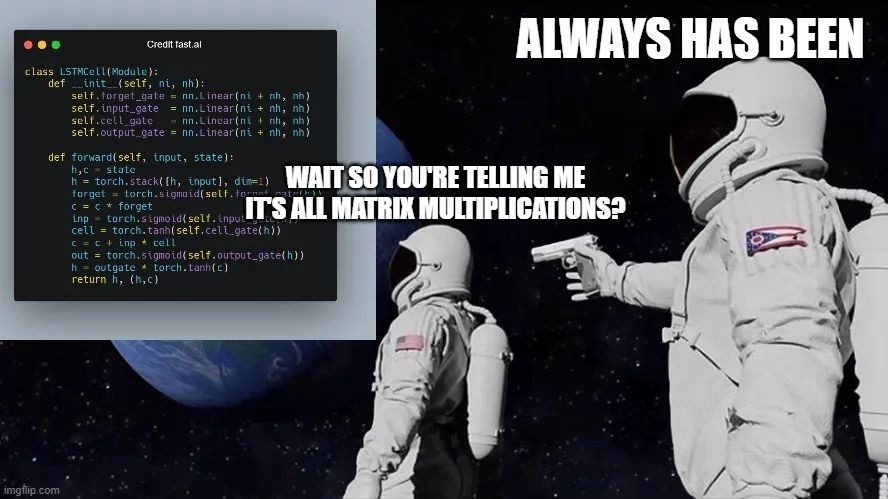

# Pytensor

`Pytensor` is the computational backend for PyMC, a popular probabilistic programming language. Pytensor is the continuation of Theano, one of the first deep learning libraries used to build and train neural networks. What makes Pytensor powerful is that is represents computation as a *static* directed acyclic graph (DAG).

This takes a bit of getting used to, but is extremely powerful.

Here we create a symbolic variable. This is very similar to what we did in sympy. It's different because we had to specify a datatype (`d` for `double`, which means `float64`), and a shape (`scalar`, meaning it's just a single number).

In [2]:
import pytensor
import pytensor.tensor as pt

x = pt.dscalar('x')
x

x

Next, we compute the log of x. Notice that we don't get out a number (what we expect from `numpy`) or a latex expression (what we expect from `sympy`). Instead, we get back a `node`. This is an object that **represents**, but does *not* perform, computation.

In [3]:
log_x = pt.log(x)
log_x

Log.0

As we chain together `Op`s, we construct a DAG which starts from `x` (the root `node`), and ends with the current object. We can see the DAG we've build so far by using `dprint`.

In [4]:
log_x.dprint()

Log [id A]
 └─ x [id B]


Why would anyone want to do this? There are several reasons. First, because pytensor has access to this DAG, it can optimize computation. For example, consider the following graph, which represents the computation $ z = \frac{xy}{y}$. 

In [5]:
x = pt.dscalar('x')
y = pt.dscalar('y')
z = x * y / y
z.dprint()

True_div [id A]
 ├─ Mul [id B]
 │  ├─ x [id C]
 │  └─ y [id D]
 └─ y [id D]


Obviously, this can be simplified to $z = x$. In general, python is not going to be able to perform this simplification for you. Pytensor, however, will inspect the graph and make these types of simplifications when we ask it to compile the graph into a function.

When we `dprint` the function (which is an optimized version of our comptuational graph), we see that the division and multiplication are gone, and we just return a copy of the input `x`.

In [6]:
f = pytensor.function([x, y], z)
pytensor.dprint(f)

DeepCopyOp [id A] 0
 └─ x [id B]


Pytensor has many surpring rewrites it can use to improve your programs. For example, consider $y = log(1 + x)$. This might seem fine to implement in a naive way:

In [7]:
import math
def log_xp1(x):
    return math.log(1 + x)

log_xp1(1)

0.6931471805599453

But this is actually totally incorrect when `x` is very small! This comes up in probabilities, where we don't want to lose track of small (but non-zero!) probabilities. 

In [8]:
log_xp1(1e-18)

0.0

If we write the same function in pytensor and compile it, pytensor will notice `log(1 + x)` on the DAG and replace it with a specialized function that does not have this loss of precision near zero

In [9]:
x = pt.dscalar('x')
y = pt.log(1 + x)
f = pytensor.function([x], y)
pytensor.dprint(f)

Log1p [id A] 0
 └─ x [id B]


In [10]:
f(1e-28)

array(1.e-28)

# Autodiff

Another advantage of having a DAG is that we can use the chain rule to automatically compute complex derivatives. We start from the end and work backwards, multiplicatively accumulating one-step derivatives. 

Modern tensor libraries like pytensor can differentiate through a surprising array of functions. For example, we can differentiate through singular value decomposition!

In [11]:
A = pt.dmatrix('A')

U, s_diag, Vh = pt.linalg.svd(A, full_matrices=False, compute_uv=True)
pt.grad(s_diag.sum(), A).dprint()

Blockwise{dot, (m,k),(k,n)->(m,n)} [id A]
 ├─ Mul [id B]
 │  ├─ Blockwise{SVD{full_matrices=False, compute_uv=True}, (m,n)->(m,k),(k),(k,n)}.0 [id C]
 │  │  └─ A [id D]
 │  └─ ExpandDims{axis=0} [id E]
 │     └─ Second [id F]
 │        ├─ Blockwise{SVD{full_matrices=False, compute_uv=True}, (m,n)->(m,k),(k),(k,n)}.1 [id C]
 │        │  └─ ···
 │        └─ ExpandDims{axis=0} [id G]
 │           └─ Second [id H]
 │              ├─ Sum{axes=None} [id I]
 │              │  └─ Blockwise{SVD{full_matrices=False, compute_uv=True}, (m,n)->(m,k),(k),(k,n)}.1 [id C]
 │              │     └─ ···
 │              └─ 1.0 [id J]
 └─ Blockwise{SVD{full_matrices=False, compute_uv=True}, (m,n)->(m,k),(k),(k,n)}.2 [id C]
    └─ ···


# An Economic Model

Enough tricks. Here's a simple deterministic RBC model, with the following features:

- One input factor ($K_t$, capital) (or maybe two, but the household inelastically supplies a unit of labor!)

- Cobb-Douglas production technology $Y_t = e^{A_t} K_t^{\alpha}$. 

- Capital is subject to a law of motion of capital $K_{t+1} = (1 - \delta)K_t + I_t$

- Households have a log utility function $U_t = \sum_{s=0}^\infty \beta^{t+s} \log(C_{t+s})$

- Household optimize subject to a budget constraint: $C_t = Y_t$.

- Exogenous shock $A_t$ is AR(1) in logs: $e^A_t = e^{\rho A_{t-1} + \varepsilon}$

- Market clearing condition $Y_t = C_t + I_t$ 


Anyway, all that leads to this system:

$$\begin{align}
C_{t+1} &= C_{t}\beta \left(\alpha K_{t+1}^{\alpha - 1} e^{A_{t+1}} - \delta + 1\right) \\
K_{t+1} &= C_{t} - K_{t} \left(1 - \delta\right) - K_{t}^{\alpha} e^{A_{t}} + \\
A_{t} &= \rho A_{t-1} + \varepsilon_t
\end{align}$$

A note on lags:

We can "lag" a vector by just slicing off the last value. This will drop the whole vector down, putting the first value in the 2nd position, and so on. Similarly, we can lead the matrix by slicing off the first value.

In [12]:
import numpy as np
t = np.arange(10)
np.c_[t[1:-1], t[:-2], t[2:]]

array([[1, 0, 2],
       [2, 1, 3],
       [3, 2, 4],
       [4, 3, 5],
       [5, 4, 6],
       [6, 5, 7],
       [7, 6, 8],
       [8, 7, 9]])

Here I set up the problem. The indexing to make lags/leads is admittedly not obvious, but the representation of the system of equations ends up being quite compact. The method is also totally agnostic to the number of timesteps we want to simulate for, so we can re-use this code easily.

I would say the strangest thing about this is that we need to duplicate code to handle the first step, since it is otherwise sliced away. 

Also full transparency; there might be some errors here related to the initial state, especially for $K$ and $A$.

In [13]:
C = pt.tensor('C', shape=(None,))
K = pt.tensor('K', shape=(None,))
A = pt.tensor('A', shape=(None,))
epsilon = pt.tensor('epsilon', shape=(None,))

alpha, beta, delta, rho = [pt.dscalar(name) for name in ['alpha', 'beta', 'delta', 'rho']]

start  =[-beta * (alpha * K[1] ** (alpha - 1) * pt.exp(A[1]) - delta + 1) + C[1] / C[0],
         C[0] - K[0] * (1 - delta) - K[0] ** alpha * pt.exp(A[0]) + K[1],
         -rho * A[0] + A[1] - epsilon[0]]

eq1 = -beta * (alpha * K[2:] ** (alpha - 1) * pt.exp(A[2:]) - delta + 1) + C[2:] / C[1:-1]
eq2 = C[1:-1] - K[1:-1] * (1 - delta) - K[1:-1] ** alpha * pt.exp(A[1:-1]) + K[2:]
eq3 = A[1:-1] - rho * A[:-2] - epsilon[1:-1]

system = pt.concatenate([pt.stack(start)[None], 
                         pt.stack([eq1, eq2, eq3]).T], 
                        axis=0)

We can compile the function an look at the computational graph that pytensor generates. Notice the use of these `Composite` nodes. These are fused computations. Pytensor is smart enough to extract the elementwise (scalar) operations being done over the vectors, and combine them into a single function. This means that the program only has to loop over the vectors once. This optimization is called *loop lifting*.

In [14]:
f = pytensor.function([C, K, A, epsilon, alpha, beta, delta, rho], system)
pytensor.dprint(f)

Join [id A] 40
 ├─ 0 [id B]
 ├─ ExpandDims{axis=0} [id C] 39
 │  └─ MakeVector{dtype='float64'} [id D] 38
 │     ├─ Composite{...}.1 [id E] 24
 │     │  ├─ alpha [id F]
 │     │  ├─ 1.0 [id G]
 │     │  ├─ Subtensor{i} [id H] 10
 │     │  │  ├─ K [id I]
 │     │  │  └─ 1 [id J]
 │     │  ├─ Subtensor{i} [id K] 23
 │     │  │  ├─ A [id L]
 │     │  │  └─ 1 [id J]
 │     │  ├─ 1.0 [id G]
 │     │  ├─ delta [id M]
 │     │  ├─ -1.0 [id N]
 │     │  ├─ beta [id O]
 │     │  ├─ Subtensor{i} [id P] 22
 │     │  │  ├─ C [id Q]
 │     │  │  └─ 1 [id J]
 │     │  └─ Subtensor{i} [id R] 12
 │     │     ├─ C [id Q]
 │     │     └─ 0 [id S]
 │     ├─ Composite{...}.1 [id T] 14
 │     │  ├─ 1.0 [id G]
 │     │  ├─ delta [id M]
 │     │  ├─ Subtensor{i} [id U] 13
 │     │  │  ├─ K [id I]
 │     │  │  └─ 0 [id S]
 │     │  ├─ Subtensor{i} [id R] 12
 │     │  │  └─ ···
 │     │  ├─ Subtensor{i} [id V] 11
 │     │  │  ├─ A [id L]
 │     │  │  └─ 0 [id S]
 │     │  ├─ alpha [id F]
 │     │  └─ Subtensor

# Simulation

To find sample paths, we will use `scipy.optimize.root`. This can solve for the zeros of a vector-valued function, but the signature is quite particular. We want to pass each vector (C, K, A) separately, but scipy expects the signature to be `f(x, *args)`. So we have to pass a single vector containing C, K, A, then split it up ourselves inside the function.

In [15]:
from functools import wraps

def wrap_func_for_scipy(f, ravel=True):
    @wraps(f)
    def inner(states, epsilon, K_init, K_final, alpha, beta, delta, rho, T):
        C, K, A = states[:T+1], states[T + 1: 2 * T], states[2 * T:]
        K = np.r_[K_init, K, K_final]
        A = np.r_[0, A, 0]
            
        return f(C, K, A, epsilon, alpha, beta, delta, rho).ravel()
    
    return inner

f_wrapper = wrap_func_for_scipy(f)

For a simulation, we can drive the model towards the steady state, which is given by:

$$\displaystyle K_{ss} = \left(\frac{\beta \left(\delta - 1\right) + 1}{\alpha \beta}\right)^{\frac{1}{\alpha - 1}}$$

In [16]:
b = 0.99
d = 0.035
a = 0.33

K_ss = ((b * (d - 1) + 1) / (a * b)) ** (1 / (a - 1))
K_ss

19.500300341685904

In [17]:
from scipy import optimize
n_steps = 100
epsilons = np.zeros(n_steps + 1)
epsilons[10] = 1
epsilons[50] = 1


res = optimize.root(
    f_wrapper,
    x0=np.full(n_steps * 3 - 1, 1),
    args=(epsilons, 2 * K_ss, K_ss, 0.33, 0.99, 0.035, 0.95, n_steps),
    method='lm'
)

In [18]:
c_star = res.x[:n_steps + 1]
k_star = np.r_[2 * K_ss, res.x[n_steps + 1: 2 * n_steps], K_ss]
A_star = np.r_[0, res.x[2*n_steps:], 0]

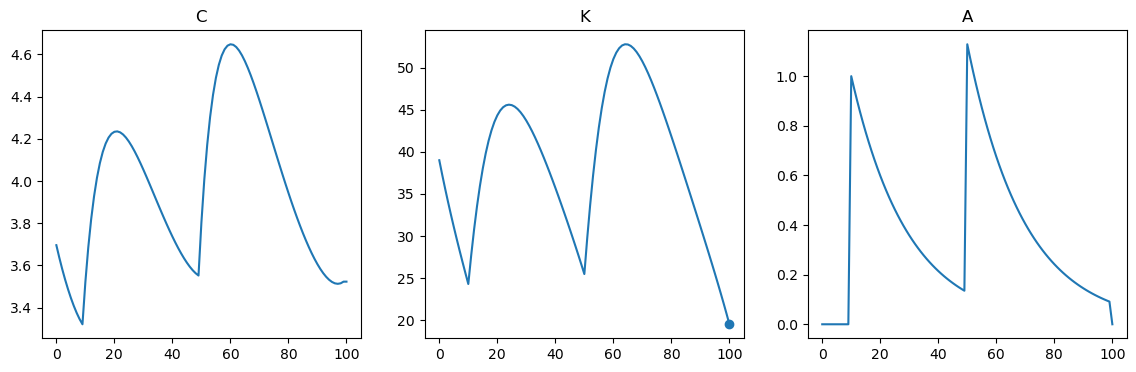

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(14,4))
for axis, trajectory, name in zip(fig.axes, [c_star, k_star, A_star], ['C', 'K', 'A']):
    axis.plot(trajectory)
    axis.set(title=name)
ax[1].scatter(n_steps, K_ss)
plt.show()

# Jacobian via Autodiff

One of the most powerful things that using a machine learning library like pytensor buys is in economics is automatic gradients for optimization. When doing a minimization problem, we can compute both the gradient vector of the loss function and the hessian matrix. In the current case, we want to compute the Jacobian matrix of the system with respect to all of the inputs.

This is done is just one line of code, using `pytensor.gradient.jacobian`

In [20]:
jac = pt.concatenate(pytensor.gradient.jacobian(system.ravel(), [C, K, A]), axis=-1)
f_jac = pytensor.function([C, K, A, epsilon, alpha, beta, delta, rho], jac)

Inspecting the Jacobian, we see it is extremely sparse, and has a block-diagonal structure. Using this naive Jacobain would probably be fine for a small problem (3 equations, 100 time steps), but would quickly become a computational burden. Remember that matrix inversion is an $\mathcal{O}(n^3)$ operation: trying to repeatedly invert large matrices (e.g. when doing optimization) will quickly bog down even extremely powerful computers.

In [21]:
J = f_jac(np.full(n_steps, 1), 
                np.full(n_steps, 1), 
                np.full(n_steps, 1), 
                np.zeros(n_steps), 
                0.33, 0.99, 0.035, 0.95)

with np.printoptions(linewidth=10000, precision=3, suppress=True, edgeitems=8, ):
    print(J[:27, :27])

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 

Another powerful optimization pytensor offers in this situation is the ability to lift expensive linear algebra operations like matrix inversion though certain other operations. Notably, it is true that $\text{BlockDiag}(A, B, C)^{-1} = \text{BlockDiag}(A^{-1}, B^{-1}, C^{-1})$ In our case, it will be much faster to invert several hundred 3x3 matrices rather than a single 300x300 matrix.

In [36]:
matrices = [pt.dmatrix() for _ in range(100)]
diag_matrix = pt.linalg.block_diag(*matrices)
inv_matrix = pt.linalg.inv(diag_matrix)
inv_matrix.dprint()

Blockwise{MatrixInverse, (m,m)->(m,m)} [id A]
 └─ Blockwise{BlockDiagonal{n_inputs=100}, (m0,n0),(m1,n1),(m2,n2),(m3,n3),(m4,n4),(m5,n5),(m6,n6),(m7,n7),(m8,n8),(m9,n9),(m10,n10),(m11,n11),(m12,n12),(m13,n13),(m14,n14),(m15,n15),(m16,n16),(m17,n17),(m18,n18),(m19,n19),(m20,n20),(m21,n21),(m22,n22),(m23,n23),(m24,n24),(m25,n25),(m26,n26),(m27,n27),(m28,n28),(m29,n29),(m30,n30),(m31,n31),(m32,n32),(m33,n33),(m34,n34),(m35,n35),(m36,n36),(m37,n37),(m38,n38),(m39,n39),(m40,n40),(m41,n41),(m42,n42),(m43,n43),(m44,n44),(m45,n45),(m46,n46),(m47,n47),(m48,n48),(m49,n49),(m50,n50),(m51,n51),(m52,n52),(m53,n53),(m54,n54),(m55,n55),(m56,n56),(m57,n57),(m58,n58),(m59,n59),(m60,n60),(m61,n61),(m62,n62),(m63,n63),(m64,n64),(m65,n65),(m66,n66),(m67,n67),(m68,n68),(m69,n69),(m70,n70),(m71,n71),(m72,n72),(m73,n73),(m74,n74),(m75,n75),(m76,n76),(m77,n77),(m78,n78),(m79,n79),(m80,n80),(m81,n81),(m82,n82),(m83,n83),(m84,n84),(m85,n85),(m86,n86),(m87,n87),(m88,n88),(m89,n89),(m90,n90),(m91,n91),(m92,n92),(

In [37]:
f = pytensor.function(matrices, inv_matrix)
pytensor.dprint(f)

BlockDiagonal{n_inputs=100} [id A] 100
 ├─ MatrixInverse [id B] 99
 │  └─ <Matrix(float64, shape=(?, ?))> [id C]
 ├─ MatrixInverse [id D] 98
 │  └─ <Matrix(float64, shape=(?, ?))> [id E]
 ├─ MatrixInverse [id F] 97
 │  └─ <Matrix(float64, shape=(?, ?))> [id G]
 ├─ MatrixInverse [id H] 96
 │  └─ <Matrix(float64, shape=(?, ?))> [id I]
 ├─ MatrixInverse [id J] 95
 │  └─ <Matrix(float64, shape=(?, ?))> [id K]
 ├─ MatrixInverse [id L] 94
 │  └─ <Matrix(float64, shape=(?, ?))> [id M]
 ├─ MatrixInverse [id N] 93
 │  └─ <Matrix(float64, shape=(?, ?))> [id O]
 ├─ MatrixInverse [id P] 92
 │  └─ <Matrix(float64, shape=(?, ?))> [id Q]
 ├─ MatrixInverse [id R] 91
 │  └─ <Matrix(float64, shape=(?, ?))> [id S]
 ├─ MatrixInverse [id T] 90
 │  └─ <Matrix(float64, shape=(?, ?))> [id U]
 ├─ MatrixInverse [id V] 89
 │  └─ <Matrix(float64, shape=(?, ?))> [id W]
 ├─ MatrixInverse [id X] 88
 │  └─ <Matrix(float64, shape=(?, ?))> [id Y]
 ├─ MatrixInverse [id Z] 87
 │  └─ <Matrix(float64, shape=(?, ?))> [id BA

In [40]:
from scipy import linalg
matrices = [np.random.normal(size=(3, 3)) for _ in range(100)]
naive_invert_time = %timeit -o np.linalg.inv(linalg.block_diag(*matrices))

2.41 ms ± 45 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
pt_invert_time = %timeit -o f(*matrices)

520 μs ± 5.34 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [42]:
naive_invert_time.average / pt_invert_time.average

4.638713558330491